## **AI & ML salaries during 2020-2023**

### By Christina Tzavara, Sarah Abdulwahid, Alex Olmeta, Catherine Tawadros, Charles Bugayer

In [2]:
import nbformat

# Load the first notebook
with open('decision_trees.ipynb', 'r') as file:
    nb1 = nbformat.read(file, as_version=nbformat.NO_CONVERT)

# Load the second notebook
with open('Project_Code.ipynb', 'r') as file:
    nb2 = nbformat.read(file, as_version=nbformat.NO_CONVERT)

# Create a new notebook
merged_nb = nbformat.v4.new_notebook()

# Combine the cells from both notebooks into the new notebook
merged_nb.cells.extend(nb1.cells)
merged_nb.cells.extend(nb2.cells)

# Save the merged notebook
with open('Project_Code_2.ipynb', 'w') as file:
    nbformat.write(merged_nb, file)

In [9]:
import pandas as pd
from pyearth import Earth
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import KNNImputer
import xgboost as xgb
import itertools as it
import time as time 
import warnings
warnings.filterwarnings('ignore')

## Data quality check / cleaning / preparation 


In [3]:
# read data

salaries = pd.read_csv("salaries.csv")
salaries.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,MI,FT,AWS Data Architect,258000,USD,258000,US,100,US,L
1,2023,SE,FT,Data Scientist,225000,USD,225000,US,0,US,M
2,2023,SE,FT,Data Scientist,156400,USD,156400,US,0,US,M
3,2023,SE,FT,Data Engineer,190000,USD,190000,US,100,US,M
4,2023,SE,FT,Data Engineer,150000,USD,150000,US,100,US,M


In [4]:
salaries.shape

(4134, 11)

#### **In this dataset, there are 4134 observations and there are 10 predictor, since we are using salary_in_usd as a response for our data analysis. The reason for this is that we want the data to be standardized across countries.**

### Distribution of response
*By Christina Tzavara*

<Figure size 1000x500 with 0 Axes>

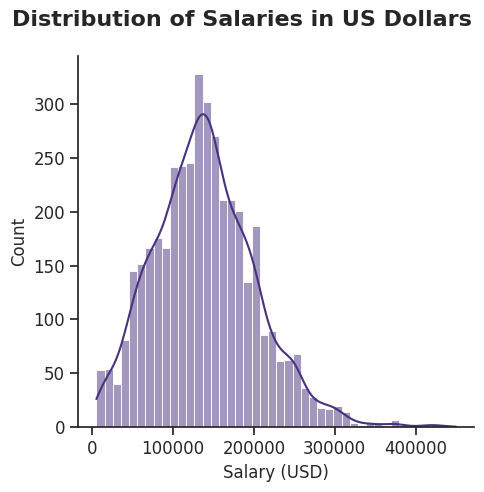

In [13]:
#Plotting distribution of our response variable, salary_in_usd

sns.set(style='ticks', palette='viridis')
plt.figure(figsize=(10, 5))
g = sns.displot(salaries['salary_in_usd'], kde=True)

# Setting plot title and axis labels with larger, bold font
g.fig.suptitle("Distribution of Salaries in US Dollars", fontsize=16, fontweight='bold')
g.set(xlabel="Salary (USD)", ylabel="Count")

# Customizing tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove the right and top spines
sns.despine(right=True, top=True)

# Adjustting plot layout
plt.tight_layout()
plt.show()


### Data cleaning
*Note: dataset is completely clean as shown below*

In [6]:
# Check for missing values
missing_values = salaries.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


### Data preparation
*By Alex Olmeta*

- We needed to bin the hundreds of job titles in 10 main categories since the names for the job positions weren't standardized.
- Alex, add comments to your code below as per the instructions

In [ ]:
salaries.job_title_binned.value_counts()

data_science_and_ml                  1534
data_engineering_and_architecture    1474
data_analysis_and_visualization       692
data_management_and_strategy          146
research_and_science                  133
business_intelligence                  50
other_data_related                     49
computer_vision                        29
ai_development                         16
nlp_engineer                           11
Name: job_title_binned, dtype: int64

In [ ]:
job_categories = {
    'data_science_and_ml': ['Data Scientist', 'Applied Scientist', 'ML Engineer', 'Machine Learning Engineer', 'Applied Machine Learning Engineer', 'Research Engineer', 'Machine Learning Developer', 'Machine Learning Scientist', 'AI Scientist', 'Machine Learning Software Engineer', 'Principal Data Scientist', 'Machine Learning Researcher', 'Decision Scientist', 'Machine Learning Research Engineer', 'Principal Machine Learning Engineer', 'Machine Learning Manager', 'Lead Machine Learning Engineer', 'Principal Data Analyst', 'Staff Data Scientist', 'Applied Machine Learning Scientist', 'Lead Data Scientist'],
    'data_engineering_and_architecture': ['AWS Data Architect', 'Data Engineer', 'Data Manager', 'Data Architect', 'Data Integration Specialist', 'ETL Developer', 'BI Data Analyst', 'Data Modeler', 'Cloud Data Engineer', 'Data Operations Analyst', 'ETL Engineer', 'Data DevOps Engineer', 'Data Quality Analyst', 'Big Data Engineer', 'BI Data Engineer', 'Cloud Database Engineer', 'Data Infrastructure Engineer', 'Software Data Engineer', 'Data Operations Engineer', 'Big Data Architect', 'Azure Data Engineer', 'Marketing Data Engineer', 'Data Management Specialist', 'Principal Data Architect', 'Cloud Data Architect', 'Principal Data Engineer', 'Machine Learning Infrastructure Engineer', 'MLOps Engineer', 'Analytics Engineer'],
    'data_analysis_and_visualization': ['Data Analyst', 'Product Data Analyst', 'Data Visualization Analyst', 'Sales Data Analyst', 'BI Developer', 'Business Data Analyst', 'Lead Data Analyst', 'BI Analyst', 'Insight Analyst', 'Marketing Data Analyst', 'Data Analytics Lead'],
    'data_management_and_strategy': ['Head of Data', 'Data Specialist', 'Director of Data Science', 'Data Science Manager', 'Data Science Lead', 'Data Strategist', 'Data Analytics Manager', 'Manager Data Management', 'Data Management Specialist'],
    'ai_development': ['Autonomous Vehicle Operations Lead', 'Autonomous Vehicle Technician', 'AI Developer', 'AI Programmer'],
    'computer_vision': ['Computer Vision Engineer', 'Computer Vision Software Engineer', '3D Computer Vision Researcher'],
    'nlp_engineer': ['NLP Engineer'],
    'business_intelligence': ['Business Intelligence Engineer', 'BI Data Analyst', 'BI Developer', 'BI Data Engineer', 'BI Analyst', 'Power BI Developer'],
    'research_and_science': ['Research Scientist', 'Applied Data Scientist', 'Data Science Consultant', 'Deep Learning Researcher', 'Deep Learning Engineer'],
    'other_data_related': ['Finance Data Analyst', 'Compliance Data Analyst', 'Data Science Tech Lead', 'Marketing Data Scientist', 'Product Data Scientist', 'Staff Data Analyst', 'Data Analytics Specialist', 'Data Analytics Engineer', 'Data Analytics Consultant', 'Data Management Specialist', 'Head of Data Science', 'Data Lead', 'Data Science Engineer', 'Insight Analyst', 'Data Science Engineer', 'Data Analytics Engineer', 'Data Analytics Consultant', 'Data Management Specialist', 'Data Scientist Lead', 'Principal Data Architect', 'Lead Data Engineer', 'Head of Machine Learning', 'Staff Data Scientist', 'Financial Data Analyst']
}

In [ ]:
# check to make sure all jobs fall in a category

not_cat = []
for i in range(len(salaries.job_title)):
    title = salaries.job_title[i]
    categorized = False
    for key in job_categories.keys():
        cat = job_categories[key]
        if title in cat:
            categorized = True
    if not categorized:
        not_cat.append(title)

list(set(not_cat))

[]

In [ ]:
# bin jobs based on category

binned_jobs = [None] * len(salaries.job_title)
for i in range(len(salaries.job_title)):
    title = salaries.job_title[i]
    categorized = False
    for key in job_categories.keys():
        cat = job_categories[key]
        if title in cat:
            binned_jobs[i] = key


salaries['job_title_binned'] = binned_jobs

In [ ]:
len(salaries.job_title_binned.unique())

10

In [ ]:
salaries.to_csv('binned_jobs.csv', index=False) 

## Exploratory data analysis
*By Christina Tzavara*

In [4]:
binned_jobs = pd.read_csv("binned_jobs.csv")
binned_jobs =  binned_jobs.drop('job_title', axis = 1)
binned_jobs =  binned_jobs.drop('salary', axis = 1)
#check updated dataset with new column job_title_binned
binned_jobs.head()

,work_year,experience_level,employment_type,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_title_binned
0,2023,MI,FT,USD,258000,US,100,US,L,data_engineering_and_architecture
1,2023,SE,FT,USD,225000,US,0,US,M,data_science_and_ml
2,2023,SE,FT,USD,156400,US,0,US,M,data_science_and_ml
3,2023,SE,FT,USD,190000,US,100,US,M,data_engineering_and_architecture
4,2023,SE,FT,USD,150000,US,100,US,M,data_engineering_and_architecture


In [ ]:
import pandas as pd
from tabulate import tabulate

# Compute summary statistics for 'salary_in_usd'
salary_stats = salaries['salary_in_usd'].describe().reset_index()
salary_stats.columns = ['Statistic', 'Value']

# Convert the summary statistics to a table
salary_table = tabulate(salary_stats, headers='keys', tablefmt='fancy_grid', showindex=False)
print("Summary Statistics for 'salary_in_usd':")
print(salary_table)


Summary Statistics for 'salary_in_usd':
╒═════════════╤══════════╕
│ Statistic   │    Value │
╞═════════════╪══════════╡
│ count       │   4134   │
├─────────────┼──────────┤
│ mean        │ 139416   │
├─────────────┼──────────┤
│ std         │  63605.5 │
├─────────────┼──────────┤
│ min         │   5132   │
├─────────────┼──────────┤
│ 25%         │  96817   │
├─────────────┼──────────┤
│ 50%         │ 136000   │
├─────────────┼──────────┤
│ 75%         │ 179820   │
├─────────────┼──────────┤
│ max         │ 450000   │
╘═════════════╧══════════╛


#### **Looking at the average values for our repsonse per job title:**

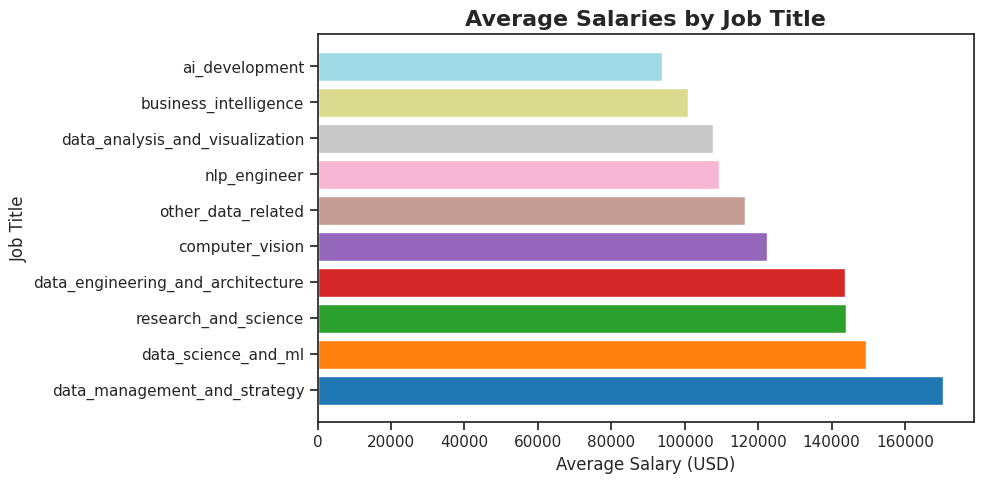

In [12]:

# Group the data by job title and calculate the average salary
average_salary_by_title = binned_jobs.groupby('job_title_binned')['salary_in_usd'].mean().sort_values(ascending=False)

# Create a bar plot with each job title having its own color
plt.figure(figsize=(10, 5))

# Generate a color map with a unique color for each job title
color_map = plt.get_cmap('tab20', len(average_salary_by_title))

# Get the list of job titles and corresponding average salaries
job_titles = average_salary_by_title.index
average_salaries = average_salary_by_title.values

# Plot each bar with a unique color
for i in range(len(job_titles)):
    plt.barh(job_titles[i], average_salaries[i], color=color_map(i))

plt.xlabel('Average Salary (USD)')
plt.ylabel('Job Title')

# Customize the title
plt.title('Average Salaries by Job Title', fontweight='bold', fontsize=16)

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()


## Developing the model: Hyperparameter tuning

### MARS 
*By Christina Tzavara*

### First, running a general baseline model:

In [5]:
binned_jobs_encoded = pd.get_dummies(binned_jobs, drop_first=True)
X = binned_jobs_encoded.drop('salary_in_usd',axis=1)
y = binned_jobs_encoded['salary_in_usd']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# Create a baseline linear regression model
baseline_model = LinearRegression()

# Fit the model on the training data
baseline_model.fit(X_train, y_train)

# Predict on the test data
y_pred = baseline_model.predict(X_test)


In [10]:
# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: $", mae)

Mean Absolute Error: $ 280696947960.07605


### Developing MARS initial model by finding max_degree that minimizes MAE:

In [ ]:
from sklearn.model_selection import GridSearchCV
from pyearth import Earth

# Define the parameter grid
param_grid = {
    'max_degree': [1, 2, 3, 4, 5]  # Vary the max_degree values as needed
}


mars = Earth()
#MAE as the scoring metric
grid_search = GridSearchCV(mars, param_grid, scoring='neg_mean_absolute_error', cv=3)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best model max_degree and MAE
print("Best Model max_degree: ", grid_search.best_params_['max_degree'])
print("MAE: ", -grid_search.best_score_)  # Convert negative score back to positive


Best Model max_degree:  1
MAE:  37315.428132284724


### Visualizing max_degree - MAE trade-off:

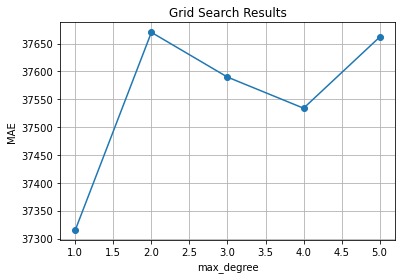

In [ ]:
import matplotlib.pyplot as plt

# Get the max_degree values and corresponding mean_test_score
max_degrees = grid_search.cv_results_['param_max_degree'].data.astype(int)
mae_scores = -grid_search.cv_results_['mean_test_score']

# Plot 
plt.plot(max_degrees, mae_scores, marker='o')
plt.xlabel('max_degree')
plt.ylabel('MAE')
plt.title('Grid Search Results')
plt.grid(True)
plt.show()


### Second MARS model after silmutaneous tuning of max_terms & max_degree:

In [ ]:
# Finer search for degree + silmutaneous tuning for max terms

#Define the parameter grid
param_grid = {
    'max_terms': [50,100, 200],  # Vary the max_terms values as needed
    'max_degree': [1, 2, 3]  # Vary the degree values as needed
}

mars = Earth()

#MAE as the scoring metric
grid_search = GridSearchCV(mars, param_grid, scoring='neg_mean_absolute_error', cv=3)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

{'max_degree': 1, 'max_terms': 50}

### Visualizing max_terms vs MAE:

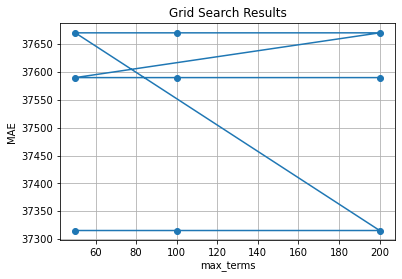

In [ ]:
# Get the max_degree values and corresponding mean_test_score
max_degrees = grid_search.cv_results_['param_max_terms'].data.astype(int)
mae_scores = -grid_search.cv_results_['mean_test_score']

# Plot
plt.plot(max_degrees, mae_scores, marker='o')
plt.xlabel('max_terms')
plt.ylabel('MAE')
plt.title('Grid Search Results')
plt.grid(True)
plt.show()


### Final optimized model MAE:

In [ ]:
model3 = Earth(max_terms = 50, max_degree=1) # note, terms in brackets are the hyperparameters 
model3.fit(X_train,y_train)

# Predict on the test data using the best model
y_pred = model3.predict(X_test)

# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Print the mean absolute error
print("Mean Absolute Error: $", mae)


Mean Absolute Error: $ 36813.0367444063


# Decision Trees with Cost Complexity Pruning
*By Sarah Abdulwahid*

### 1) Untuned & Unpruned Decision Tree Regressor Model

In [31]:
model = DecisionTreeRegressor(random_state=0) 
model.fit(X_train, y_train)
mean_absolute_error(model.predict(X_test), y_test)

37495.05557190754

### 2) Getting max depth and max leaf nodes for ranges in GridSearch to tune these hyperparameters.

In [32]:
print("Maximum tree depth =", model.get_depth())
print("Maximum leaves =", model.get_n_leaves())

Maximum tree depth = 44
Maximum leaves = 632


In [33]:
# Coarse grid-search 
parameters = {'max_depth':range(2,44, 2),
              'max_leaf_nodes':range(2,632, 10)}

cv = KFold(n_splits = 5,shuffle=True,random_state=1)
model = GridSearchCV(DecisionTreeRegressor(random_state=1), parameters, n_jobs=-1,verbose=1,cv=cv, 
                    scoring='neg_mean_absolute_error')

model.fit(X_train, y_train)
print (model.best_score_, model.best_params_) 

Fitting 5 folds for each of 1323 candidates, totalling 6615 fits
-37326.32686683002 {'max_depth': 6, 'max_leaf_nodes': 42}


### 3) Plotting results of 5-fold cross validation to narrow range for finer grid search

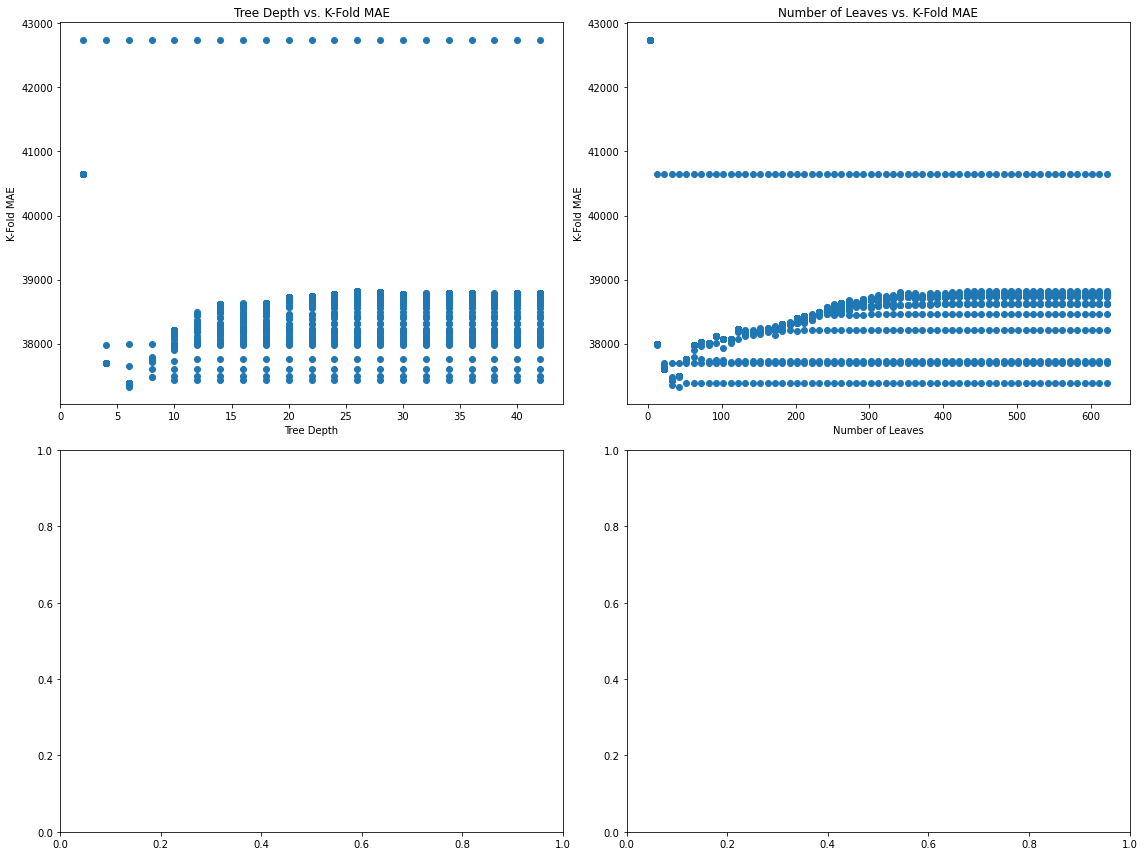

In [34]:
# Detailed results of k-fold cross validation
cv_results = pd.DataFrame(model.cv_results_)

# Create the figure and axes with adjusted size
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.3)

# Plot Tree Depth vs. K-Fold MAE
axes[0, 0].plot(cv_results.param_max_depth, -cv_results.mean_test_score, 'o')
axes[0, 0].set_xlabel('Tree Depth')
axes[0, 0].set_ylabel('K-Fold MAE')
axes[0, 0].set_title('Tree Depth vs. K-Fold MAE')

# Plot Number of Leaves vs. K-Fold MAE
axes[0, 1].plot(cv_results.param_max_leaf_nodes, -cv_results.mean_test_score, 'o')
axes[0, 1].set_xlabel('Number of Leaves')
axes[0, 1].set_ylabel('K-Fold MAE')
axes[0, 1].set_title('Number of Leaves vs. K-Fold MAE')
# Adjust the size of the plots on the screen
plt.tight_layout()

# Display the plots
plt.show()


In [53]:
# Finer grid search
parameters = {'max_depth':range(4,10, 1),
              'max_leaf_nodes':range(2,200, 5)}
cv = KFold(n_splits = 5,shuffle=True,random_state=1)
model = GridSearchCV(DecisionTreeRegressor(random_state=1), parameters, n_jobs=-1,verbose=1,cv=cv, 
                    scoring='neg_mean_absolute_error')
model.fit(X_train, y_train)
print (model.best_score_, model.best_params_) 

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
-37326.32686683002 {'max_depth': 6, 'max_leaf_nodes': 42}


### 4) Fit a new Decision Tree Regressor with tuned hyperparameters

In [54]:
model = DecisionTreeRegressor(random_state=1, max_depth=6, max_leaf_nodes=40).fit(X_train, y_train)
mean_absolute_error(model.predict(X_test), y_test)

36561.470960578925

### 5) Cost-Complexity Pruning: use cost_complexity_pruning_path to find a range of alpha values to consider for tuning process

In [59]:
model = DecisionTreeRegressor(random_state = 1)#model without any restrictions
path= model.cost_complexity_pruning_path(X_train,y_train)# Compute the pruning path during Minimal Cost-Complexity Pruning.
alphas=path['ccp_alphas']

### 6) Perform 5-fold CV to find the optimal alpha that minimizes MAE

In [45]:
cv = KFold(n_splits = 5,shuffle=True,random_state=1)
tree = GridSearchCV(DecisionTreeRegressor(random_state=1), param_grid = {'ccp_alpha':alphas}, 
                     scoring = 'neg_mean_absolute_error',n_jobs=-1,verbose=1,cv=cv)
tree.fit(X, y)
print (tree.best_score_, tree.best_params_)
print("Time taken =",round((tm.time()-start_time)/60), "minutes")

Fitting 5 folds for each of 505 candidates, totalling 2525 fits
-37385.459996302816 {'ccp_alpha': 8824077.621291757}
Time taken = 0 minutes


### 7) Use this alpha to fit a new Decision Tree Regressor and get optimized model MAE

In [46]:
model = DecisionTreeRegressor(ccp_alpha=8824077.621291757,random_state=1)
model.fit(X, y)
pred = model.predict(X_test)
mean_absolute_error(y_test, pred)

36258.07866139093

# Gradient Boosting
*By Charles Bugayer*

This is the base GradientBoosting Model and its resulting MAE.

In [ ]:
base = GradientBoostingRegressor()
scores = cross_val_score(base, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
-scores.mean()

36775.600316829295

For efficiency, I used RandomizedSearchCV with 100000 iterations, as a GridSearchCV would be totalling 9878400 fits with 5-fold cross validation.

In [ ]:
gbr = GradientBoostingRegressor()
gbr_params = {'n_estimators': [100, 120, 140, 160, 170, 180, 200],
                'max_depth': [3,4,5,6,7,8],
                'learning_rate': [0,0.01, 0.001, 0.1, 0.095, 0.4, 0.2],
                'subsample': [0,0.1, 0.3, 0.8, 1.0],
              'min_samples_split': [2,3,4,5],
              'min_samples_leaf': [0.1,0.3,0.5,0.7,0.9,1],
              'min_weight_fraction_leaf': [0,0.1,0.3,0.5,0.7,0.9,1],
              'criterion': ['friedman_mse', 'squared_error'],
              'loss': ['huber', 'log_loss', 'deviance', 'exponential']}
gbr_gridsearch = RandomizedSearchCV(gbr, gbr_params, n_iter = 100000, cv=5, verbose=1, n_jobs=-1, scoring='neg_mean_absolute_error')
gbr_gridsearch.fit(X_train, y_train)
print('Best gbr params:', gbr_gridsearch.best_params_)
print('Best gbr score:', gbr_gridsearch.best_score_)

Best gbr params: {'subsample': 1.0, 'n_estimators': 160, 'min_weight_fraction_leaf': 0, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 3, 'loss': 'huber', 'learning_rate': 0.095, 'criterion': 'squared_error'}
Best gbr score: -36322.8451418078

After getting the initial best parameters, I used GridSearchCV to find the best parameters in a smaller range. After a couple of rounds of tuning, n_estimators moved to a higher value than the first round would have suggested. Because the value for min_samples_split was on the edge of the range, I increased the range.

In [ ]:
gbr = GradientBoostingRegressor()
gbr_params = {'n_estimators': range(172,190),
                'max_depth': [2,3,4,5],
                'learning_rate': [0.094, 0.095, 0.096],
                'subsample': [1.0],
              'min_samples_split': range(4,11),
              'min_samples_leaf': [1],
              'min_weight_fraction_leaf': [0],
              'loss': ['huber']}
gbr_gridsearch = GridSearchCV(gbr, gbr_params, cv=5, verbose=1, n_jobs=-1, scoring='neg_mean_absolute_error')
gbr_gridsearch.fit(X_train, y_train)
print('Best gbr params:', gbr_gridsearch.best_params_)
print('Best gbr score:', gbr_gridsearch.best_score_)

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=189, max_depth=3, learning_rate=0.095, subsample=1.0, min_samples_split=7, min_samples_leaf=1, min_weight_fraction_leaf=0, loss='huber', subsample=1.0)

Best gbr params: {'learning_rate': 0.095, 'loss': 'huber', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0, 'n_estimators': 189, 'subsample': 1.0}
Best gbr score: -36216.57778386479


After this round of tuning, the MAE on train data only got worse, so I decided to stop there.

# XGBoost Model Development
By Alex Olmeta

In [ ]:
data = pd.read_csv('binned_jobs.csv')

data.head()

In [ ]:
y1 = data['salary_in_usd']

X1 = data.drop(columns=['salary_in_usd', 'job_title', 'salary'], axis=1)
X1 = pd.get_dummies(X1, drop_first=True)

In [ ]:
# Scaling test data

sc = StandardScaler()
sc.fit(X1)

X_scaled = sc.transform(X1)
X1 = pd.DataFrame(X_scaled)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=45)

In this next section I looped through to test the best values of individual hyperparameters on base models. I then used this insight as a starting place for my random search. For sake of redundancy, I will only show the code I used to show the best number of trees on a base XGBoost model since testing for the other hyperparameters was the same process and essentially the same code.

In [ ]:
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [5, 10, 50, 100, 500, 1000, 2000, 5000]
    for n in n_trees:
        models[str(n)] = xgb.XGBRegressor(n_estimators=n,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

I then ran the following broad RandomSearchCV using my previous findings to narrow down the potential hyperparameter range. I used 3 fold cross validation because the range quite large and the code took several hours to execute

In [15]:
start_time = time.time()
param_grid = {'max_depth': [4,6,8,12,15],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 1, 10, 100],
                'n_estimators':[1000, 2000, 3000, 4000],
                'gamma': [0, 10, 100, 10000, 1e6, 1e9] ,
                'subsample': [0.5, 0.75, 1.0]
                }

cv = KFold(n_splits=3,shuffle=True,random_state=45)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=45),                                                       
                             param_distributions = param_grid, n_iter = 500,
                             verbose = 1,
                             n_jobs=-1,
                             scoring='neg_mean_absolute_error',
                             cv = cv)
optimal_params.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 2 folds for each of 500 candidates, totalling 1000 fits
Optimal parameter values = {'subsample': 0.5, 'reg_lambda': 100, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 10}
Optimal cross validation R-squared =  -36568.345355902624
Time taken =  142  minutes


I then ran a further, finer RandomSearchCV based on the results of the last broad random search. Again I used three folds to strike a balance between computation time and accuracy.

In [16]:
start_time = time.time()
param_grid = {'max_depth': [7,8,9],
              'learning_rate': [0.01, 0.025, 0.05, 0.1],
               'reg_lambda':[0, 1, 10, 100],
                'n_estimators':[1000, 1500, 2000, 2500],
                'gamma': [0, 10, 100, 10000, 1e6, 1e9] ,
                'subsample': [0.5, 0.625, 0.75, 0.875, 1.0]
                }

cv = KFold(n_splits=3,shuffle=True,random_state=45)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=45),                                                       
                             param_distributions = param_grid, n_iter = 500,
                             verbose = 1,
                             n_jobs=-1,
                             scoring='neg_mean_absolute_error',
                             cv = cv)
optimal_params.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 2 folds for each of 200 candidates, totalling 400 fits
Optimal parameter values = {'subsample': 0.625, 'reg_lambda': 100, 'n_estimators': 1500, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 10}
Optimal cross validation R-squared =  -36488.927135106496
Time taken =  37  minutes


After this I tried many rounds of manual hyperparameter tuning. This included trying values in and outside of the range I narrowed in on. I also performed further random and grid searches but none producted a model with a lower cross validated mae on the data. The following model contains my final hyperparameters I found.

Also, I used the huber loss function because it helped mitigate the impact of several very large outliers

In [ ]:
model = xgb.XGBRegressor(max_depth=7,n_estimators=2600,learning_rate=0.016, reg_lambda= 100,
                         random_state=1,subsample=0.68,gamma=10,loss='huber')

# RandomForest Model Development
By Catherine Tawadros

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score, mean_absolute_error

#Libraries for visualizing trees
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image
import time as tm

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
binned_jobs = pd.read_csv("binned_jobs.csv")
binned_jobs.drop(['job_title', 'salary'], axis = 1)

# Convert categorical variables to dummy variables
binned_jobs_encoded = pd.get_dummies(binned_jobs, drop_first=True)

# Separate the features (X) and the target variable (y)
X = binned_jobs_encoded.drop(['salary_in_usd', 'salary'],axis=1)
y = binned_jobs_encoded['salary_in_usd']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

## parameter tuning iterations, each more specific than the previous:

In [26]:
parameters = {'max_depth': np.arange(5,50,7), "max_features": np.arange(4,10,2), 'max_leaf_nodes': np.arange(1000,2500,200), 'bootstrap':[True, False], 'ccp_alpha': np.arange(0.0, .5, 0.1)}
cv = KFold(n_splits = 2, shuffle=True, random_state=1)
model = RandomizedSearchCV(RandomForestRegressor(random_state=1, n_estimators=50), parameters, n_jobs=-1, n_iter=250, verbose=1, cv=cv, scoring="neg_mean_absolute_error")
model.fit(X_train, y_train)
print (model.best_params_)

Fitting 2 folds for each of 250 candidates, totalling 500 fits
{'max_leaf_nodes': 2400, 'max_features': 4, 'max_depth': 33, 'ccp_alpha': 0.1, 'bootstrap': True}


In [27]:
parameters = {'max_depth': np.arange(5,50,7), "max_features": np.arange(2,10,2), 'max_leaf_nodes': np.arange(2000,4000,500), 'bootstrap':[True], 'ccp_alpha': np.arange(0.05, .15, 0.05)}
cv = KFold(n_splits = 2, shuffle=True, random_state=1)
model2 = RandomizedSearchCV(RandomForestRegressor(random_state=1, n_estimators=50), parameters, n_jobs=-1, n_iter=250, verbose=1, cv=cv, scoring="neg_mean_absolute_error")
model2.fit(X_train, y_train)
print (model2.best_params_)

C:\Users\ctawa\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 224 is smaller than n_iter=250. Running 224 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 224 candidates, totalling 448 fits
{'max_leaf_nodes': 2000, 'max_features': 4, 'max_depth': 33, 'ccp_alpha': 0.05, 'bootstrap': True}


In [52]:
parameters = {'max_depth': np.arange(5,50,7), "max_features": np.arange(2,8,1), 'max_leaf_nodes': np.arange(2000,2500,100), 'bootstrap':[True], 'ccp_alpha': np.arange(0.025, .1, 0.025)}
cv = KFold(n_splits = 2, shuffle=True, random_state=1)
model3 = RandomizedSearchCV(RandomForestRegressor(random_state=1, n_estimators=100), parameters, n_jobs=-1, n_iter=250, verbose=1, cv=cv, scoring="neg_mean_absolute_error")
model3.fit(X_train, y_train)
print (model3.best_params_)

Fitting 2 folds for each of 250 candidates, totalling 500 fits
{'max_leaf_nodes': 2400, 'max_features': 4, 'max_depth': 33, 'ccp_alpha': 0.07500000000000001, 'bootstrap': True}


In [49]:
parameters = {'max_depth': [30,33,36], "max_features": [4], 'max_leaf_nodes': [2400], 'bootstrap':[True], 'ccp_alpha': [.075], 'oob_score':[True,False]}
cv = KFold(n_splits = 4, shuffle=True, random_state=1)
model4 = RandomizedSearchCV(RandomForestRegressor(random_state=1, n_estimators=100), parameters, n_jobs=-1, n_iter=250, verbose=1, cv=cv, scoring="neg_mean_absolute_error")
model4.fit(X_train, y_train)
print (model4.best_params_)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
{'oob_score': True, 'max_leaf_nodes': 2400, 'max_features': 4, 'max_depth': 36, 'ccp_alpha': 0.075, 'bootstrap': True}


In [33]:
parameters = {'max_depth': [34,36,38], "max_features": [4], 'max_leaf_nodes': [2400], 'bootstrap':[True], 'ccp_alpha': [.075], 'oob_score':[True], 'criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson']}
cv = KFold(n_splits = 4, shuffle=True, random_state=1)
model5 = RandomizedSearchCV(RandomForestRegressor(random_state=1, n_estimators=100), parameters, n_jobs=-1, n_iter=250, verbose=1, cv=cv, scoring="neg_mean_absolute_error")
model5.fit(X_train, y_train)
print (model5.best_params_)

C:\Users\ctawa\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 12 is smaller than n_iter=250. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 4 folds for each of 12 candidates, totalling 48 fits
{'oob_score': True, 'max_leaf_nodes': 2400, 'max_features': 4, 'max_depth': 38, 'criterion': 'absolute_error', 'ccp_alpha': 0.075, 'bootstrap': True}


In [34]:
preds = model5.predict(X_test)
np.sqrt(mean_squared_error(y_test, preds))

49486.09454826788

In [36]:
parameters = {'oob_score': [True], 'max_leaf_nodes': [2400], 'max_features': [4], 'max_depth': [38], 'criterion': ['absolute_error'], 'ccp_alpha': [0.075], 'bootstrap': [True]}
cv = KFold(n_splits = 4, shuffle=True, random_state=1)
model6 = RandomizedSearchCV(RandomForestRegressor(random_state=1, n_estimators=2500), parameters, n_jobs=-1, n_iter=1, verbose=1, cv=cv, scoring="neg_mean_absolute_error")
model6.fit(X_train, y_train)
preds = model6.predict(X_test)
np.sqrt(mean_squared_error(y_test, preds))

Fitting 4 folds for each of 1 candidates, totalling 4 fits


49479.01528064572

## Visualization of model performance:

Text(0.5, 1.0, 'model MAE')

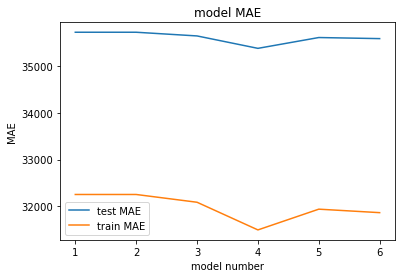

In [57]:
l = [model, model2, model3, model4, model5, model6]
bests = []
bests_t = []
for m in l:
    bests.append(mean_absolute_error(m.predict(X_test), y_test))
    bests_t.append(mean_absolute_error(m.predict(X_train), y_train))
sns.lineplot(x=[1,2,3,4,5,6], y=bests, label="test MAE")
plt.xlabel("model number")
plt.ylabel("MAE")
sns.lineplot(x=[1,2,3,4,5,6], y=bests_t, label = "train MAE")
plt.title("model MAE")

Text(0.5, 1.0, 'model MAE')

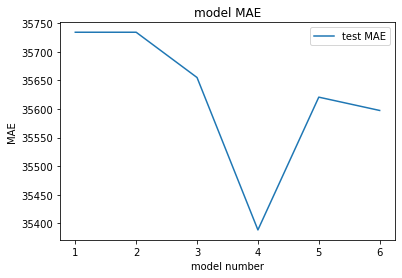

In [58]:
sns.lineplot(x=[1,2,3,4,5,6], y=bests, label="test MAE")
plt.xlabel("model number")
plt.ylabel("MAE")
plt.title("model MAE")

In [54]:
# best MAE across each iteration of grid/randomized search
bests

[35734.21531427414,
 35734.21531427414,
 35655.02933215456,
 35388.54260580971,
 35620.710737605805,
 35597.43756058041]

In [59]:
parameters = {'max_depth': [30,33,36], "max_features": [4], 'max_leaf_nodes': [2400], 'bootstrap':[True], 'ccp_alpha': [.075], 'oob_score':[True,False]}
cv = KFold(n_splits = 4, shuffle=True, random_state=1)
model4 = RandomizedSearchCV(RandomForestRegressor(random_state=1, n_estimators=1000), parameters, n_jobs=-1, n_iter=250, verbose=1, cv=cv, scoring="neg_mean_absolute_error")
model4.fit(X_train, y_train)
print (model4.best_params_)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
{'oob_score': True, 'max_leaf_nodes': 2400, 'max_features': 4, 'max_depth': 36, 'ccp_alpha': 0.075, 'bootstrap': True}


In [60]:
# FINAL TEST MAE
mean_absolute_error(y_test, model4.predict(X_test))

35292.425234087365

In [64]:
y_pred = model4.predict(X_test)
# Convert y_pred array to a DataFrame
df_pred = pd.DataFrame({'y_pred': y_pred})

# Save the DataFrame to a CSV file
df_pred.to_csv('random_forest_predictions.csv', index=False)

In [63]:
# Feature importance can be found by averaging the feature importance in individual trees
# this is mainly for reference in the recommendations to stakeholders section
feature_importances = np.mean([
    tree.feature_importances_ for tree in model4.best_estimator_.estimators_
], axis=0)
series = pd.Series(feature_importances, X_train.columns).sort_values(ascending=False)

employee_residence_US                 0.072878
experience_level_SE                   0.071320
salary_currency_USD                   0.070693
company_location_US                   0.070281
work_year                             0.054844
                                        ...   
salary_currency_HKD                   0.000000
job_title_AWS Data Architect          0.000000
salary_currency_CZK                   0.000000
company_location_VN                   0.000000
job_title_Head of Machine Learning    0.000000
Length: 290, dtype: float64

In [68]:
y_pred = model4.predict(X_test)
# Convert y_pred array to a DataFrame
df_pred = pd.DataFrame({'y_pred': y_pred, 'y_true': y_test})

# Save the DataFrame to a CSV file
df_pred.to_csv('random_forest_predictions_with_ytest.csv', index=False)

# ENSEMBLING MODELS
By Catherine Tawadros

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score,mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from pyearth import Earth
import warnings
warnings.filterwarnings('ignore')

In [2]:
X_train = pd.read_csv("X_train.csv", index_col=0)
X_test = pd.read_csv("X_test.csv", index_col=0)
y_train = pd.read_csv("y_train.csv", index_col=0)
y_test = pd.read_csv("y_test.csv", index_col=0)
cv = KFold(5, shuffle=True, random_state=12)

## base models:

In [53]:
# MARS MODEL
ma = Earth(max_terms=50, max_degree=1)
ma_train_preds = cross_val_predict(ma, X_train, y_train, cv = cv)
ma_train_preds_df = pd.DataFrame(ma_train_preds)
ma_train_preds_df.to_csv("ma_train_preds.csv")

In [54]:
ma.fit(X_train, y_train)
ma_test_preds = ma.predict(X_test)
ma_test_preds_df = pd.DataFrame(ma_test_preds)
ma_test_preds_df.to_csv("ma_test_preds.csv")

In [52]:
# BAGGING MODEL
bg = BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=1), random_state=1, n_estimators=200, bootstrap=True, bootstrap_features=False, max_features=.75, max_samples=.5)
bg.fit(X_train, y_train)
bg_train_preds = cross_val_predict(bg, X_train, y_train, cv = cv)
bg_train_preds_df = pd.DataFrame(bg_train_preds)
bg_train_preds_df.to_csv("bg_train_preds.csv")

In [55]:
bg.fit(X_train, y_train)
bg_test_preds = bg.predict(X_test)
bg_test_preds_df = pd.DataFrame(bg_test_preds)
bg_test_preds_df.to_csv("bg_test_preds.csv")

In [80]:
# RANDOM FOREST MODEL
rf = RandomForestRegressor(random_state=1, criterion="absolute_error", n_estimators=100, max_leaf_nodes=2400, max_features=4, max_depth=36, oob_score=True, bootstrap=True, ccp_alpha=.075)
rf.fit(X_train, y_train)
rf_train_preds = cross_val_predict(rf, X_train, y_train, cv = cv)
rf_train_preds_df = pd.DataFrame(rf_train_preds)
rf_train_preds_df.to_csv("rf_train_preds.csv")

In [81]:
rf.fit(X_train, y_train)
rf_test_preds = rf.predict(X_test)
rf_test_preds_df = pd.DataFrame(rf_test_preds)
rf_test_preds_df.to_csv("rf_test_preds.csv")

In [4]:
# GRADIENT BOOSTING MODEL
gb = GradientBoostingRegressor(random_state=1, n_estimators=189, max_depth=3, learning_rate=0.095, subsample=1.0, min_samples_split=7, min_samples_leaf=1, min_weight_fraction_leaf=0, loss='huber')
gb_train_preds = cross_val_predict(gb, X_train, y_train, cv = cv)
gb_train_preds_df = pd.DataFrame(rf_train_preds)
gb_train_preds_df.to_csv("gb_train_preds.csv")

In [28]:
gb.fit(X_train, y_train)
gb_test_preds = gb.predict(X_test)
gb_test_preds_df = pd.DataFrame(gb_test_preds)
gb_test_preds_df.to_csv("gb_test_preds.csv")

In [8]:
# XGB MODEL
xg = xgb.XGBRegressor(max_depth=7,n_estimators=1500,learning_rate=0.01, reg_lambda= 100,
                         random_state=1,subsample=0.625,gamma=10)
xg_train_preds = cross_val_predict(xg, X_train, y_train, cv = cv)
xg_train_preds_df = pd.DataFrame(xg_train_preds)
xg_train_preds_df.to_csv("xg_train_preds.csv")

[04:17:00] WARNING: ../src/learner.cc:767: 
Parameters: { "loss" } are not used.

[04:18:00] WARNING: ../src/learner.cc:767: 
Parameters: { "loss" } are not used.

[04:18:34] WARNING: ../src/learner.cc:767: 
Parameters: { "loss" } are not used.

[04:19:28] WARNING: ../src/learner.cc:767: 
Parameters: { "loss" } are not used.

[04:20:02] WARNING: ../src/learner.cc:767: 
Parameters: { "loss" } are not used.



In [13]:
xg.fit(X_train, y_train)
xg_test_preds = xg.predict(X_test)
xg_test_preds_df = pd.DataFrame(xg_test_preds)
xg_test_preds_df.to_csv("xg_test_preds.csv")

[04:22:45] WARNING: ../src/learner.cc:767: 
Parameters: { "loss" } are not used.



In [82]:
# read in test predictions
ma_test_preds_csv = pd.read_csv("ma_test_preds.csv")
bg_test_preds_csv = pd.read_csv("bg_test_preds.csv")
rf_test_preds_csv = pd.read_csv("rf_test_preds.csv")
gb_test_preds_csv = pd.read_csv("gb_test_preds.csv")
xg_test_preds_csv = pd.read_csv("xg_test_preds.csv")
ma_test_preds = np.asarray(ma_test_preds_csv["0"])
bg_test_preds = np.asarray(bg_test_preds_csv["0"])
rf_test_preds = np.asarray(rf_test_preds_csv["0"])
gb_test_preds = np.asarray(gb_test_preds_csv["0"])
xg_test_preds = np.asarray(xg_test_preds_csv["0"])

In [83]:
# base model MAEs for future comparison
print("MARS MAE:")
print(mean_absolute_error(y_test, ma_test_preds))
print("Bagging MAE:")
print(mean_absolute_error(y_test, bg_test_preds))
print("RandomForest MAE:")
print(mean_absolute_error(y_test, rf_test_preds))
print("GradientBooster MAE:")
print(mean_absolute_error(y_test, gb_test_preds))
print("XGB MAE:")
print(mean_absolute_error(y_test, xg_test_preds))

MARS MAE:
36966.12909507691
Bagging MAE:
35962.31408492376
RandomForest MAE:
36044.76051390568
GradientBooster MAE:
36033.63512253498
XGB MAE:
35679.131675937126


In [84]:
# compile train and test predictors for metamodels
all_test_preds = np.transpose(np.stack([ma_test_preds, bg_test_preds, rf_test_preds, gb_test_preds, xg_test_preds]))
all_train_preds = np.transpose(np.stack([ma_train_preds, bg_train_preds, rf_train_preds, gb_train_preds, xg_train_preds]))

In [131]:
# VOTING MODEL
meta_vt_test_preds = np.mean(all_test_preds, axis=1)
meta_vt_train_preds = np.mean(all_train_preds, axis=1)
print(mean_absolute_error(y_test, meta_vt_test_preds))

35671.828809594466


In [123]:
# STACKED LINEAR MODEL
meta_ln = LinearRegression()
meta_ln.fit(all_train_preds, y_train)
meta_ln_test_preds = meta_ln.predict(all_test_preds)
print(mean_absolute_error(y_test, meta_ln_test_preds))

35758.66450925252


In [133]:
meta_ln_train_preds = cross_val_predict(meta_ln, all_train_preds, y_train, cv = cv)

In [125]:
# STACKED RANDOM FOREST MODEL
meta_rf_params = {"max_features": [1,2,3], "max_depth": [2, 5, 10], "bootstrap": [True, False], "ccp_alpha": [.001, .01, .1]}
meta_rf = RandomForestRegressor(random_state=1)
meta_rf_grid = GridSearchCV(meta_rf, meta_rf_params, scoring="neg_mean_absolute_error", n_jobs=-1, cv=cv)
meta_rf_grid.fit(all_train_preds, y_train)
print(meta_rf_grid.best_params_)
meta_rf_test_preds = meta_rf_grid.predict(all_test_preds)
print(mean_absolute_error(y_test, meta_rf_test_preds))

{'bootstrap': True, 'ccp_alpha': 0.1, 'max_depth': 10, 'max_features': 1}
35606.6262933011


In [126]:
meta_rf = RandomForestRegressor(random_state=1, bootstrap=True, ccp_alpha=.1, max_depth=10, max_features=1)
meta_rf_train_preds = cross_val_predict(meta_rf, all_train_preds, y_train, cv = cv)

In [127]:
# STACKED XGBOOST MODEL
meta_xg_params = {"subsample": [.25, .5, .75, 1], "learning_rate": [.001, .01, .1], "alpha": [.05, .1, .5, 1]}
meta_xg = xgb.XGBRegressor(random_state=1)
meta_xg_grid = GridSearchCV(meta_xg, meta_xg_params, scoring="neg_mean_absolute_error", n_jobs=-1, cv=cv)
meta_xg_grid.fit(all_train_preds, y_train)
print(meta_xg_grid.best_params_)
meta_xg_test_preds = meta_xg_grid.predict(all_test_preds)
print(mean_absolute_error(y_test, meta_xg_test_preds))

{'alpha': 0.5, 'learning_rate': 0.1, 'subsample': 1}
36157.0764871618


In [128]:
meta_xg = xgb.XGBRegressor(random_state=1, alpha=.1, learning_rate=.1, subsample=1)
meta_xg_train_preds = cross_val_predict(meta_xg, all_train_preds, y_train, cv = cv)

In [129]:
# VOTING METAMETA MODEL
meta_test_preds = np.transpose(np.stack([meta_vt_test_preds, meta_ln_test_preds.flatten(), meta_rf_test_preds]))
metameta_test_preds = np.mean(meta_test_preds, axis=1)
print(mean_absolute_error(metameta_test_preds, y_test))

35569.19911845313


In [134]:
# METAMETA LINEAR REGRESSION MODEL
meta_extra_test_preds = np.transpose(np.stack([meta_vt_test_preds, meta_ln_test_preds.flatten(), meta_rf_test_preds, meta_xg_test_preds]))
meta_train_preds = np.transpose(np.stack([meta_vt_train_preds, meta_ln_train_preds.flatten(), meta_rf_train_preds, meta_xg_train_preds]))
metameta_ln_model = LinearRegression().fit(meta_train_preds, y_train)
metameta_ln_test_preds = metameta_ln_model.predict(meta_extra_test_preds)
print(mean_absolute_error(metameta_ln_test_preds, y_test))

35510.69402672526


In [138]:
# METAMETA RANDOM FOREST MODEL
# metameta_rf_params = {"max_features": [1,2,3], "max_depth": [5, 10, 20], "oob_score": [True, False], "ccp_alpha": [.001, .01, .1]}
# metameta_rf = RandomForestRegressor(random_state=1, bootstrap=True)
# metameta_rf_grid = GridSearchCV(metameta_rf, metameta_rf_params, scoring="neg_mean_absolute_error", n_jobs=-1, cv=cv)
# metameta_rf_grid.fit(meta_train_preds, y_train)
# print(metameta_rf_grid.best_params_)
# metameta_rf_test_preds = metameta_rf_grid.predict(meta_extra_test_preds)
# print(mean_absolute_error(y_test, metameta_rf_test_preds))

this model was bad.

## Results of each base model and ensembled model

In [136]:
col1 = 'model_type'
list1 = ['MARS', 'BaggingRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor', 'XGBRegressor', 'Voting', 'LinearRegression', 'RandomForestRegressor', 'XGBRegressor', 'Voting', 'LinearRegression']
col2 = "model"
list2 = [ma, bg, rf, gb, xg, np.mean, meta_ln, meta_rf, meta_xg, np.mean, metameta_ln_model]
col3 = 'test_predictions'
list3 = [ma_test_preds, bg_test_preds, rf_test_preds, gb_test_preds, xg_test_preds, meta_vt_test_preds, meta_ln_test_preds, meta_rf_test_preds, meta_xg_test_preds, metameta_test_preds, metameta_ln_test_preds]
col4 = 'model_level'
list4 = [1,1,1,1,1,2,2,2,2,3,3]
all_models = pd.DataFrame(data = {col1:list1, col2:list2, col4:list4})
all_models["MAE"] = list(map(lambda x: mean_absolute_error(x, y_test), list3))
all_models["RMSE"] = list(map(lambda x: np.sqrt(mean_squared_error(x, y_test)), list3))
all_models

,model_type,model,model_level,MAE,RMSE
0,MARS,"Earth(max_degree=1, max_terms=50)",1,36966.129095,49756.778999
1,BaggingRegressor,(DecisionTreeRegressor(random_state=1028862084...,1,35962.314085,49008.562799
2,RandomForestRegressor,"(DecisionTreeRegressor(ccp_alpha=0.075, criter...",1,36044.760514,50005.958054
3,GradientBoostingRegressor,([DecisionTreeRegressor(criterion='friedman_ms...,1,36033.635123,49690.104180
4,XGBRegressor,"XGBRegressor(base_score=None, booster=None, ca...",1,35679.131676,49125.461608
5,Voting,<function mean at 0x7ff4ea7c12d0>,2,35671.828810,48979.558239
6,LinearRegression,LinearRegression(),2,35758.664509,48984.964197
7,RandomForestRegressor,"RandomForestRegressor(ccp_alpha=0.1, max_depth...",2,35606.626293,48882.229066
8,XGBRegressor,"XGBRegressor(alpha=0.1, base_score=None, boost...",2,36157.076487,49247.803209
9,Voting,<function mean at 0x7ff4ea7c12d0>,3,35569.199118,48816.591080


In [143]:
# export final predictions into a csv file
y_test_array = np.asarray(y_test).flatten()
final = pd.DataFrame(data = {"predicted": metameta_ln_test_preds.flatten(), "y_true": y_test_array})
final.to_csv("final_predictions.csv")

# Limitations
*By Charles Bugayer*

Our model is limited by the fact that we only have 4134 observations. This is a relatively small dataset, and we would have liked to have more observations to train our model on. We were able to predict salaries with a MAE of 35510.69, which is a relatively large error. We would have liked to have a smaller error, but we believe that this is the best we could do with the data we had.


# Conclusions and Recommendations
*By Charles Bugayer*

Being that for our models, employee_residence_US was an important feature, it is clear that both companies and employees should be aware of the differences in salaries between countries. 

Because our model doesn't predict salaries above $350k, we recommend that companies and employees be aware of the fact that our model is not accurate for salaries above this amount. 